# Implementing a Neural Network for CIFAR dataset
In this exercise, you should change H.W_1 to work on the CIFAR dataset.

CIFAR is a dataset that consists of 60,000 32x32 colour images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with 6000 images per class.

We will have the same components as were in the previous exercise:
- Loading the data and visualize some of the images
- Training the model. Instead of loading a pre-trained model, we will define a new very basic architecture.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

## 1) Loading CIFAR dataset (10 points)

You should load the CIFAR dataset. You can use [the pytorch CIFAR tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). As was done in the previous exercise, you should define a dictionary of ``dataloaders``. For now, no need to define pre-process to the data.
Please stick to the API of H.W_1, create a dataloaders disctionary ``{'train','val'}``

You can use batch_size = 128

In [4]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
  }

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Check for the availability of a GPU, and use CPU otherwise
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for mac
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

**If you manage to load the CIFAR data correctly, you should run the next three cells and see some of the images.**

## Visualize some of the training images

In this dataset the size of the images are 32x32.

It is important to visualize the data in order to see that we load them correctly (maybe we need to divide by 255? should we make channel permutations?)

The code below was taken from H.W_1

In [5]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [6]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

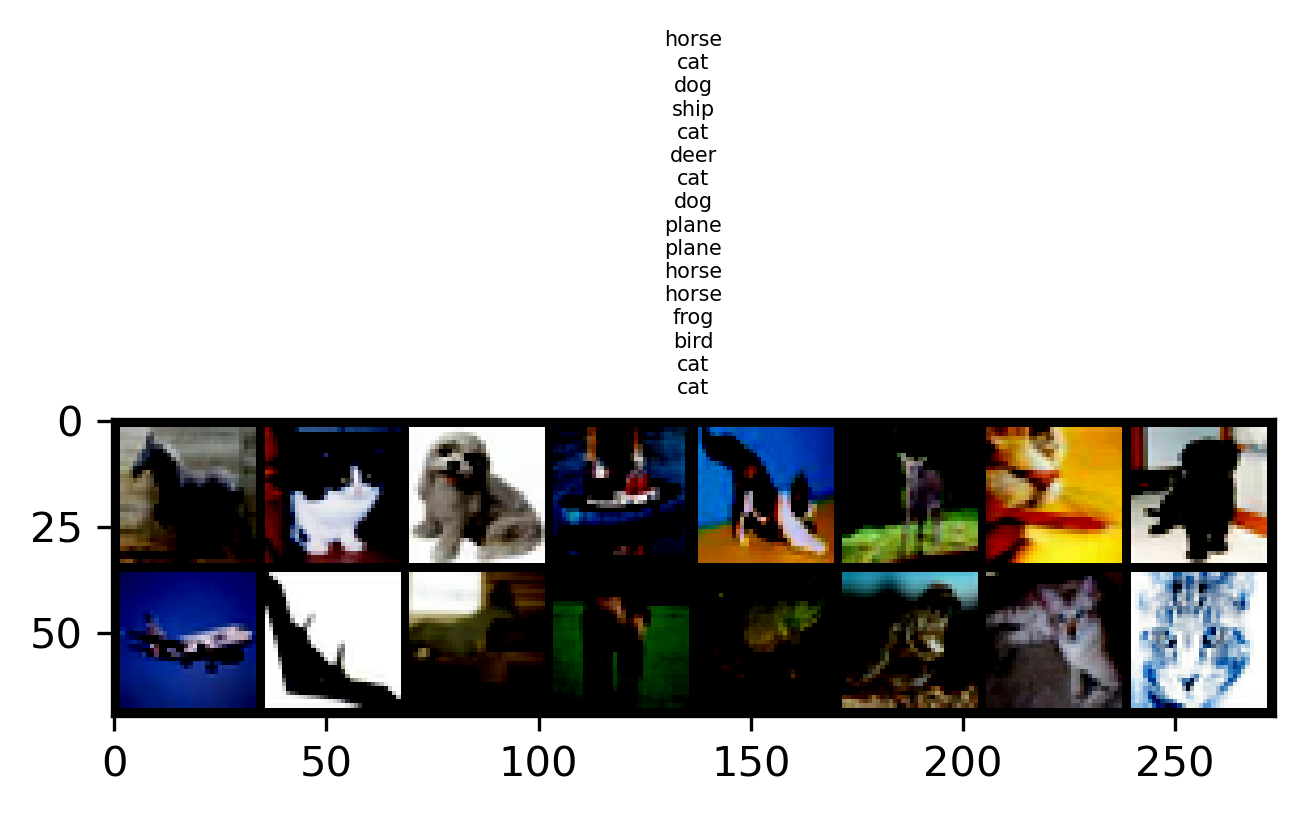

In [7]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## A 2-layer Neural Network

We will define 2-fully-connected-layer network using Sequential module. We have two hidden layers: the first one has 100 neurons and the second one has 20 neurons. The last layer is the output that has 10 elements.

Please pay attention that we take images after flattening (line 15 below).

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


**Pay attention, in case you change something in the parameters, the data, data loaders, image transform, optimizations and more...you should load the model again so it will start from random weights and not from the last training**.

**You should run again the line** ``model = NeuralNetwork().to(device)``


The next two cells (defining the loss and the training loop) were copied from last exercise.


In [10]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [11]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) #
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / (len(trainset) if phase == 'train' else len(testset))
            epoch_acc = running_corrects.float() / (len(trainset) if phase == 'train' else len(testset)) # running_corrects.double() doesn't work for mac

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model = train_model(model,
                    dataloaders,
                     criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 2.1982 Acc: 0.2112
val Loss: 2.0689 Acc: 0.2660

Epoch 1/9
----------
train Loss: 1.9740 Acc: 0.2981
val Loss: 1.8950 Acc: 0.3206

Epoch 2/9
----------
train Loss: 1.8470 Acc: 0.3462
val Loss: 1.8040 Acc: 0.3645

Epoch 3/9
----------
train Loss: 1.7702 Acc: 0.3731
val Loss: 1.7369 Acc: 0.3848

Epoch 4/9
----------
train Loss: 1.7117 Acc: 0.3929
val Loss: 1.6877 Acc: 0.4036

Epoch 5/9
----------
train Loss: 1.6647 Acc: 0.4090
val Loss: 1.6462 Acc: 0.4139

Epoch 6/9
----------
train Loss: 1.6267 Acc: 0.4237
val Loss: 1.6135 Acc: 0.4282

Epoch 7/9
----------
train Loss: 1.6015 Acc: 0.4340
val Loss: 1.6090 Acc: 0.4291

Epoch 8/9
----------
train Loss: 1.5976 Acc: 0.4345
val Loss: 1.6057 Acc: 0.4317

Epoch 9/9
----------
train Loss: 1.5941 Acc: 0.4362
val Loss: 1.6025 Acc: 0.4308

Training complete in 8m 32s
Best val Acc: 0.431700


You can continue after you see your model learns something (the training loss is decreasing).

# 2) Losses in Pytorch (10 points)

Now that you managed to run the training loop, let's understand the loss definition. PyTorch provides losses such as cross-entropy loss (`nn.CrossEntropyLoss`) that has just been used. You'll usually see the loss assigned to `criterion`. For classification problems such as CIFAR, we use the softmax function to predict class probabilities. With a softmax output, we need to use cross-entropy as the loss. To actually calculate the loss, we first define the criterion, then pass in it the output of your network and the correct labels.

*Important note!* Look at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

It means that we need to pass in `nn.CrossEntropyLoss` the raw output of our network into, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities, which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually better to avoid doing calculations with probabilities, and generally we use log-probabilities.

**Exercise:** Change the network above to output the log-softmax and calculate the loss using the negative log-likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.


In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        lsm_output = nn.LogSoftmax(dim=1)(logits)
        return lsm_output
    

# If a GPU is available, make the model use it
model =  NeuralNetwork().to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.NLLLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

acc_l_tr, acc_l_val, loss_l_tr, loss_l_val = [], [], [], []    

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) #
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / (len(trainset) if phase == 'train' else len(testset))
            epoch_acc = running_corrects.float() / (len(trainset) if phase == 'train' else len(testset)) # running_corrects.double() doesn't work for mac

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
              acc_l_tr.append(epoch_acc)
              loss_l_tr.append(epoch_loss)
            else:
              acc_l_val.append(epoch_acc)
              loss_l_val.append(epoch_loss)

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
model = train_model(model,
                    dataloaders,
                    criterion,
                    optimizer_ft,
                    exp_lr_scheduler,
                    num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.2049 Acc: 0.1805
val Loss: 2.0639 Acc: 0.2918

Epoch 1/9
----------
train Loss: 1.9531 Acc: 0.3240
val Loss: 1.8582 Acc: 0.3540

Epoch 2/9
----------
train Loss: 1.8119 Acc: 0.3670
val Loss: 1.7572 Acc: 0.3866

Epoch 3/9
----------
train Loss: 1.7278 Acc: 0.3935
val Loss: 1.6888 Acc: 0.4069

Epoch 4/9
----------
train Loss: 1.6679 Acc: 0.4137
val Loss: 1.6386 Acc: 0.4253

Epoch 5/9
----------
train Loss: 1.6231 Acc: 0.4295
val Loss: 1.6062 Acc: 0.4355

Epoch 6/9
----------
train Loss: 1.5884 Acc: 0.4422
val Loss: 1.5769 Acc: 0.4460

Epoch 7/9
----------
train Loss: 1.5633 Acc: 0.4510
val Loss: 1.5707 Acc: 0.4491

Epoch 8/9
----------
train Loss: 1.5594 Acc: 0.4523
val Loss: 1.5675 Acc: 0.4506

Epoch 9/9
----------
train Loss: 1.5562 Acc: 0.4534
val Loss: 1.5650 Acc: 0.4505

Training complete in 8m 36s
Best val Acc: 0.450600


# 3) Debug the training (15 points)
With the default parameters we provided above (and without any preprocess or augmentations), you should get a validation accuracy of about 0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

**Exersice:** Write this visualization here.
(you can copy your solution from last exercies)


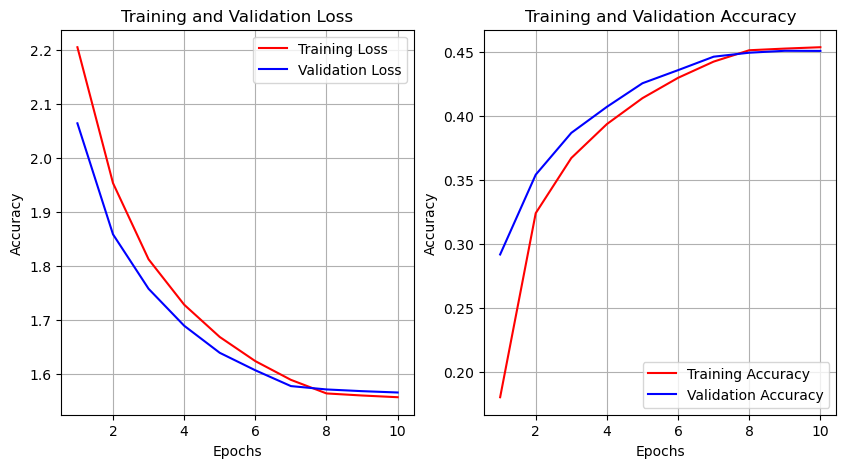

In [18]:
plt.figure(figsize=(10, 5))
epochs = range(1, num_epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_l_tr, 'r', label='Training Loss')
plt.plot(epochs, loss_l_val, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, [a.cpu().numpy() for a in acc_l_tr], 'r', label='Training Accuracy')
plt.plot(epochs, [a.cpu().numpy() for a in acc_l_val], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show();



# 4) Tune your hyperparameters (50 points)

**What's wrong?**. Looking at the loss above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including *hidden layer size, learning rate, numer of training epochs, and adding l2 or l1 regularization to the cross entropy loss*. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [20]:

#################################################################################
# TODO: Tune hyperparameters using the validation set.                          #
#                                                                               #
#                                                                               #

# hidden layer size
hidden_ls = [[100, 20], [150, 30], [180, 40]]

# learning rate
learning_r = [0.001, 0.005, 0.01]

# number of training epochs
num_epochs = [10, 15, 20, 25]

# adding l2 or l1 regularization to the cross entropy loss
l1_reg = [0, 1e-5]
l2_reg = [0, 1e-5]

#################################################################################
# Your code

class NeuralNetwork(nn.Module):
    def __init__(self, hls):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, hls[0]),
            nn.ReLU(),
            nn.Linear(hls[0], hls[1]),
            nn.ReLU(),
            nn.Linear(hls[1], 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
best_hls, best_lr, best_nepoch, best_epoch, best_l1, best_l2 = None, None, None, None, None, None, 
best_acc = 0.0
best_model_wts = None

# Example structure for training with hyperparameter tuning
for hls in hidden_ls:
    for lr in learning_r:
        for ne in num_epochs:
            for l1_strength in l1_reg:
                for l2_strength in l2_reg:
                    model = NeuralNetwork(hls).to(device)
                    print(model)
                    optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=0.9) #, weight_decay=l2_strength)
                    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
                    criterion = nn.CrossEntropyLoss()

                    num_epochs = ne

                    def train_model(model, dataloaders, criterion, optimizer, scheduler, best_acc, num_epochs=25):
                        since = time.time()

                        # Init variables that will save info about the best model
                        # best_model_wts = copy.deepcopy(model.state_dict())
                        # best_acc = 0.0

                        acc_l_tr, acc_l_val, loss_l_tr, loss_l_val =[], [], [], []

                        print(f'''hidden layer size: {hls}\nlearning rate: {lr}\nnumber of training epochs: {num_epochs}\nl1 regularization: {l1_strength}\nl2 regularization: {l2_strength}\n''')

                        for epoch in range(num_epochs):
                            
                            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
                            print('-' * 10)

                            # Each epoch has a training and validation phase
                            for phase in ['train', 'val']:
                                if phase == 'train':
                                    # Set model to training mode.
                                    model.train()
                                else:
                                    # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                                    model.eval()

                                running_loss = 0.0
                                running_corrects = 0

                                # Iterate over data
                                for inputs, labels in dataloaders[phase]:
                                    # Prepare the inputs for GPU/CPU
                                    inputs = inputs.to(device)
                                    labels = labels.to(device)

                                    # zero the parameter gradients
                                    optimizer.zero_grad()

                                    # ===== forward pass ======
                                    with torch.set_grad_enabled(phase=='train'):
                                        # If we're in train mode, we'll track the gradients to allow back-propagation
                                        outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                                        _, preds = torch.max(outputs, 1) #
                                        loss = criterion(outputs, labels)

                                        # L1 Regularization
                                        if l1_strength > 0:
                                            l1_reg_ = torch.tensor(0.).to(device)
                                            for param in model.parameters():
                                                l1_reg_ += torch.norm(param, 1)
                                            loss += l1_strength * l1_reg_

                                        # L2 Regularization
                                        if l2_strength > 0:
                                            l2_reg_ = torch.tensor(0.).to(device)
                                            for param in model.parameters():
                                                l2_reg_ += torch.norm(param, 2)**2
                                            loss += l2_strength * l2_reg_


                                        # ==== backward pass + optimizer step ====
                                        # This runs only in the training phase
                                        if phase == 'train':
                                            loss.backward() # Perform a step in the opposite direction of the gradient
                                            optimizer.step() # Adapt the optimizer

                                    # Collect statistics
                                    running_loss += loss.item() * inputs.size(0)
                                    running_corrects += torch.sum(preds == labels.data)

                                if phase == 'train':
                                    # Adjust the learning rate based on the scheduler
                                    scheduler.step()

                                epoch_loss = running_loss / (len(trainset) if phase == 'train' else len(testset)) # dataset_sizes[phase]
                                # epoch_acc = running_corrects.double() / len(trainset) if phase == 'train' else len(testset) # dataset_sizes[phase]
                                # to work with mse
                                epoch_acc = running_corrects.float() / (len(trainset) if phase == 'train' else len(testset)) # dataset_sizes[phase]

                                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                                if phase == 'train':
                                    acc_l_tr.append(epoch_acc)
                                    loss_l_tr.append(epoch_loss)
                                else:
                                    acc_l_val.append(epoch_acc)
                                    loss_l_val.append(epoch_loss)

                                # Keep the results of the best model so far
                                if phase == 'val' and epoch_acc > best_acc:
                                    best_acc = epoch_acc
                                    # deepcopy the model
                                    best_model_wts = copy.deepcopy(model.state_dict())
                                    best_hls = hls
                                    best_lr = lr
                                    best_nepoch = num_epochs
                                    best_epoch = epoch
                                    best_l1 = l1_strength
                                    best_l2 = l2_strength

                            print()

                        time_elapsed = time.time() - since
                        print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
                        print(f'Best val Acc: {best_acc:4f}')
                        print(f'''Best hidden layer size: {best_hls}\nBest learning rate: {best_lr}\nBest number of training epochs{best_nepoch}\n\
                              Best epoch: {best_epoch}\nBest l1 regularization: {best_l1}\nBest l2 regularization: {best_l2}''')

                        # load best model weights
                        model.load_state_dict(best_model_wts)
                        return model
                    
                    model = train_model(model,
                                        dataloaders,
                                        criterion,
                                        optimizer_ft,
                                        exp_lr_scheduler,
                                        best_acc=best_acc,
                                        num_epochs=num_epochs)

print(f'Best val Acc: {best_acc:4f}')
print(f'''Best hidden layer size: {best_hls}\nBest learning rate: {best_lr}\nBest number of training epochs{best_nepoch}\n\
        Best epoch: {best_epoch}\nBest l1 regularization: {best_l1}\nBest l2 regularization: {best_l2}''')

#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)
hidden layer size: [100, 20]
learning rate: 0.001
number of training epochs: 10
l1 regularization: 0
l2 regularization: 0

Epoch 0/9
----------
train Loss: 2.2264 Acc: 0.2090
val Loss: 2.1045 Acc: 0.2762

Epoch 1/9
----------
train Loss: 1.9993 Acc: 0.2939
val Loss: 1.9061 Acc: 0.3277

Epoch 2/9
----------
train Loss: 1.8551 Acc: 0.3432
val Loss: 1.7992 Acc: 0.3626

Epoch 3/9
----------
train Loss: 1.7683 Acc: 0.3742
val Loss: 1.7300 Acc: 0.3926

Epoch 4/9
----------
train Loss: 1.7074 Acc: 0.3946
val Loss: 1.6777 Acc: 0.4109

Epoch 5/9
----------
train Loss: 1.6590 Acc: 0.4129
val Loss: 1.6362 Acc: 0.4251

Epoch 6/9
----------
train Loss: 1.6185 Acc: 0.4281
val Loss: 1.602

# Interview Question (15 points)

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

*Your answer*:
1. Train on a larger dataset.
3. Increase the regularization strength.

*Your explanation:*
Train on a larger dataset: Increasing the size of the training dataset can help the model generalize better. A larger dataset is likely to cover a more comprehensive range of inputs that the model might encounter, reducing the model's ability to memorize the training data and instead encouraging it to learn general patterns that apply to both seen and unseen data.<br>
Increase the regularization strength: Regularization techniques, such as L1 or L2 regularization, add a penalty on the magnitude of model parameters. This can prevent the model weights from becoming too optimized for the training data (hence too large), leading to better generalization. Other technique is dropout, that increases randomness during training by temporarily dropping units (along with their connections) from the network, preventing units from co-adapting too much. This encourages the model to learn redundant representations, making it more robust and improving generalization to unseen data.